In [ ]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import re
import datetime

In [19]:
"""
TODO:
- clean up code
- adapt functions to classification
- save figures into directory
"""

'\nTODO:\n- clean up code\n- adapt functions to classification\n- save figures into directory\n'

### Import

In [3]:
def load_data(dir_path):
    """Load data from pickle files
    
    Keyword arguments:
    file_path -- path to pickle files
    Return: dicts for each file
    """
    with open(dir_path + "output_data_features_class", "rb") as f:
        features_class = pkl.load(f)
    with open(dir_path + "output_data_features_num", "rb") as f:
        features_num = pkl.load(f)
    with open(dir_path + "output_data_votes_class", "rb") as f:
        votes_class = pkl.load(f)
    with open(dir_path + "output_data_votes_num", "rb") as f:
        votes_num = pkl.load(f)
        
    return features_class, features_num, votes_class, votes_num 
    
    

In [4]:
fc, fn, vc, vn = load_data("../../data/")
with open("../../data/kev.json", "r") as f:
    kev = json.load(f)['vulnerabilities']
kev_set = {i["cveID"] for i in kev}

### Exploratory Data Analysis

In [5]:
def get_cvelist(text):
    pattern = r"^\*\*CVEs\*\*: (.*)$"
    match = re.search(pattern, text, re.MULTILINE)
    if match:
        cve_list = match.group(1).split(', ')
        if cve_list == ['']:
            return None
        else:   
            return list(set(cve_list))
    else:
        return None

In [6]:
df_fn = pd.DataFrame(fn)
df_fn = df_fn.drop(columns=["cve"])
df_fn["cves"] = df_fn["description"].apply(lambda x: get_cvelist(x))
df_fn["in_kev"] = df_fn["cves"].apply(lambda cve_list: any(cve in kev_set for cve in cve_list) if cve_list else False)
df_fn["id"] = df_fn["id"] - 1
df_fn.head(2)

,id,title,date,description,severity,vuln_id_from_tool,mitigation,epss_score,epss_percentile,cves,in_kev
0,20,'/.//WEB-INF/' Information Disclosure Vulnerab...,2025-04-27,**Name**: '/.//WEB-INF/' Information Disclosur...,High,1.3.6.1.4.1.25623.1.0.117707,VendorFix\n\nThe following vendor fixes are kn...,0.80074,0.99031,[CVE-2021-41381],False
1,0,Check for Discard Service (TCP)_153.94.175.79_...,2025-04-27,**Name**: Check for discard Service (TCP)\n**H...,High,1.3.6.1.4.1.25623.1.0.11367,"Mitigation\n\n- Under Unix systems, comment ou...",0.00467,0.63176,[CVE-1999-0636],False


In [7]:
df_vn = pd.DataFrame(vn)
df_vn["vote_num"] = pd.to_numeric(df_vn["vote_num"])
df_vn = df_vn.rename(columns={"id": "finding_id"})
df_vn["timestamp"] = pd.to_datetime(df_vn["timestamp"], format="ISO8601")
df_vn["finding_id"] = df_vn["finding_id"] - 1
df_vn.head(2)

,finding_id,user_id,vote_num,timestamp
0,0,5,10,2025-04-27 21:48:59.950631+00:00
1,0,10,6,2025-04-29 22:05:19.193009+00:00


In [8]:
# NULL_VOTE = -1

# def get_vote_means(df: pd.DataFrame, vote_column: str = "vote_num") -> np.ndarray:
#     """Get the average vote for each finding"""
#     findings = df["finding_id"].unique()
    
#     mean_votes = np.full(len(findings), NULL_VOTE)
    
#     for finding in findings:
#       finding_rows = df["finding_id"] == finding
      
#       mean_votes[finding] = df[finding_rows][vote_column].mean()
    
#     return mean_votes
  
def get_vote_means(df):
    return df.groupby("finding_id").agg({"vote_num": "mean"}).copy()
  
def get_intern_votes(df: pd.DataFrame, vote_column: str = "vote_num") -> np.ndarray:
    """Get all intern votes for each finding"""
    
    intern_votes = {}
    
    for user_id, user_group in df.groupby("user_id"):
      intern_votes[user_id] = dict(zip(user_group["finding_id"], user_group[vote_column]))
    
    return intern_votes

In [9]:
has_cve = set(np.array(df_fn[df_fn["cves"].notnull() & ~ df_fn["in_kev"]]["id"]))
in_kev = set(np.array(df_fn[df_fn["in_kev"]]["id"]))
no_cve = set(np.array(df_fn[df_fn["cves"].isnull()]["id"]))

In [10]:
## get the average votes for each 
mean_votes = get_vote_means(df_vn)
interns = get_intern_votes(df_vn)

In [11]:
df_fn.sort_values(by="id", ascending=True).head()

,id,title,date,description,severity,vuln_id_from_tool,mitigation,epss_score,epss_percentile,cves,in_kev
1,0,Check for Discard Service (TCP)_153.94.175.79_...,2025-04-27,**Name**: Check for discard Service (TCP)\n**H...,High,1.3.6.1.4.1.25623.1.0.11367,"Mitigation\n\n- Under Unix systems, comment ou...",0.00467,0.63176,[CVE-1999-0636],False
4,1,"GitLab < 13.8.8, 13.9.x < 13.9.6, 13.10.x < 13...",2025-04-27,"**Name**: GitLab < 13.8.8, 13.9.x < 13.9.6, 13...",High,1.3.6.1.4.1.25623.1.0.147118,"VendorFix\n\nUpdate to version 13.8.8, 13.9.6,...",0.94479,0.99997,[CVE-2021-22205],True
2,2,D-Link DNS/DNR Devices Multiple Vulnerabilitie...,2025-04-27,**Name**: D-Link DNS/DNR Devices Multiple Vuln...,High,1.3.6.1.4.1.25623.1.0.152068,WillNotFix\n\nNo solution was made available b...,0.94402,0.99969,"[CVE-2024-3272, CVE-2024-7715, CVE-2024-3273, ...",True
17,3,VNC Brute Force Login_153.94.225.237_5901/tcp,2025-04-27,**Name**: VNC Brute Force Login\n**Host**: 153...,High,1.3.6.1.4.1.25623.1.0.106056,Mitigation\n\nChange the password to something...,NaN,NaN,None,False
12,4,Report Default Community Names of the SNMP Age...,2025-04-27,**Name**: Report default community names of th...,High,1.3.6.1.4.1.25623.1.0.10264,VendorFix\n\nDetermine if the detected communi...,0.92333,0.99700,"[CVE-1999-0792, CVE-2004-1775, CVE-2024-5460, ...",False


In [12]:
has_cve

{0, 4, 5, 6, 7, 8, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 26}

In [13]:
votes_intern = df_vn[df_vn["user_id"] == 5]
votes_intern

,finding_id,user_id,vote_num,timestamp
0,0,5,10,2025-04-27 21:48:59.950631+00:00
7,1,5,10,2025-04-27 21:49:01.751120+00:00
14,2,5,8,2025-04-27 21:49:03.675372+00:00
21,3,5,7,2025-04-27 21:49:05.246230+00:00


In [14]:
mean_votes.head()

,vote_num
finding_id,
0,5.714286
1,9.714286
2,9.142857
3,8.142857
4,7.666667


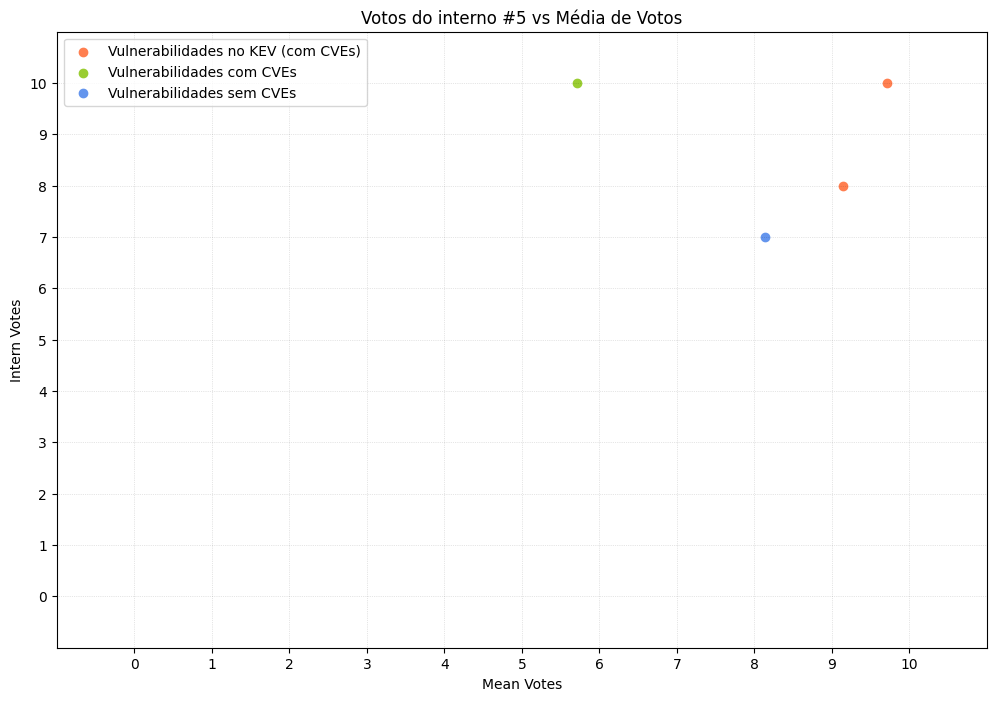

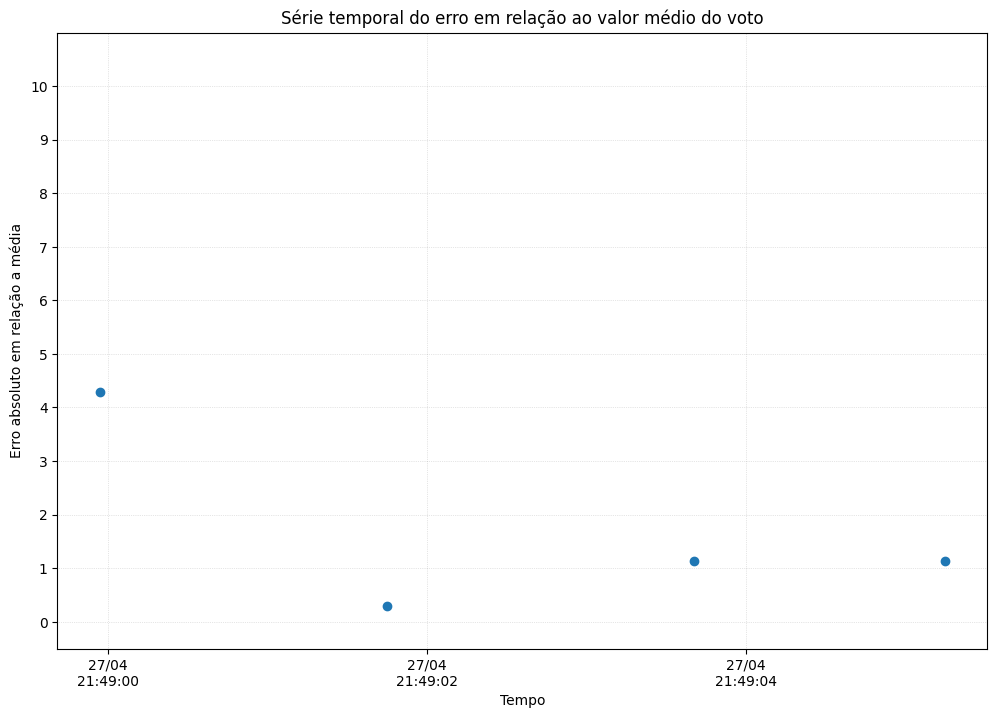

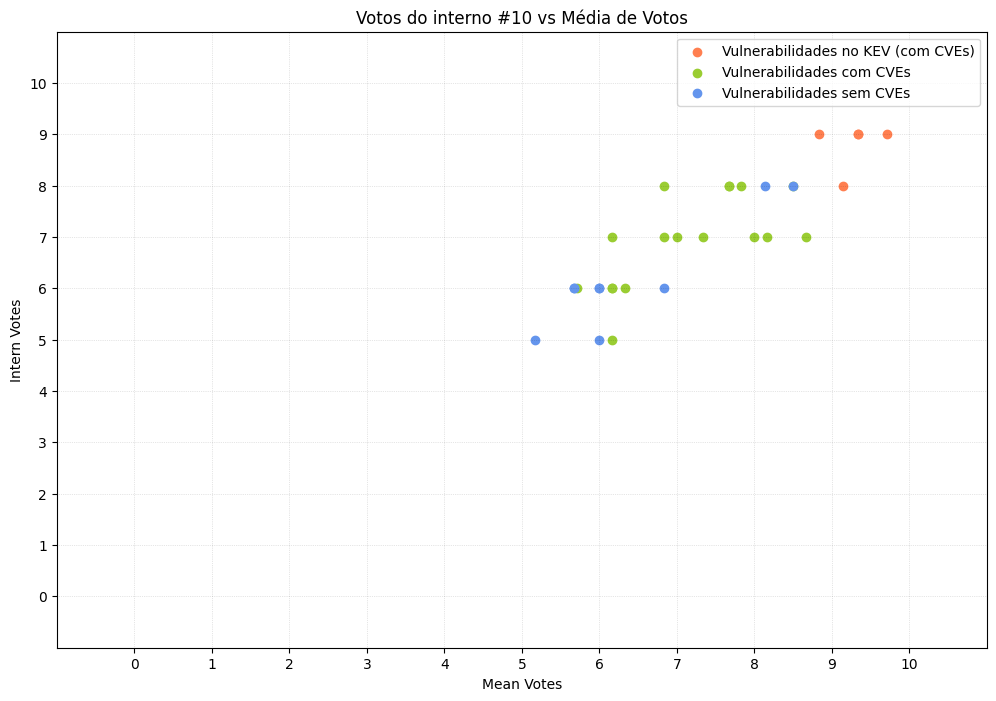

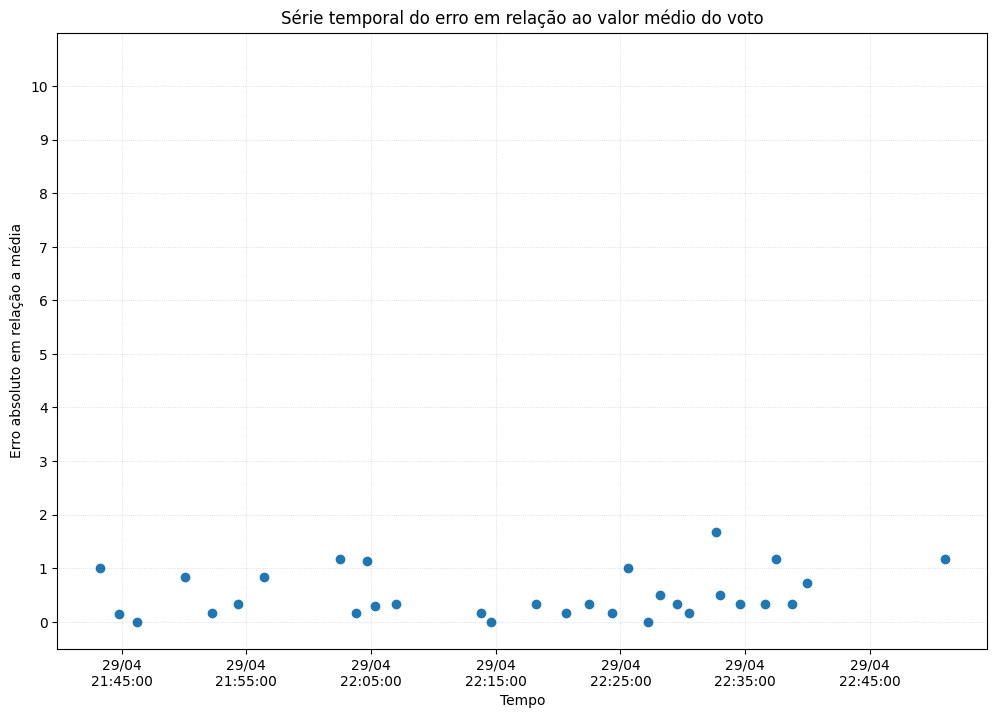

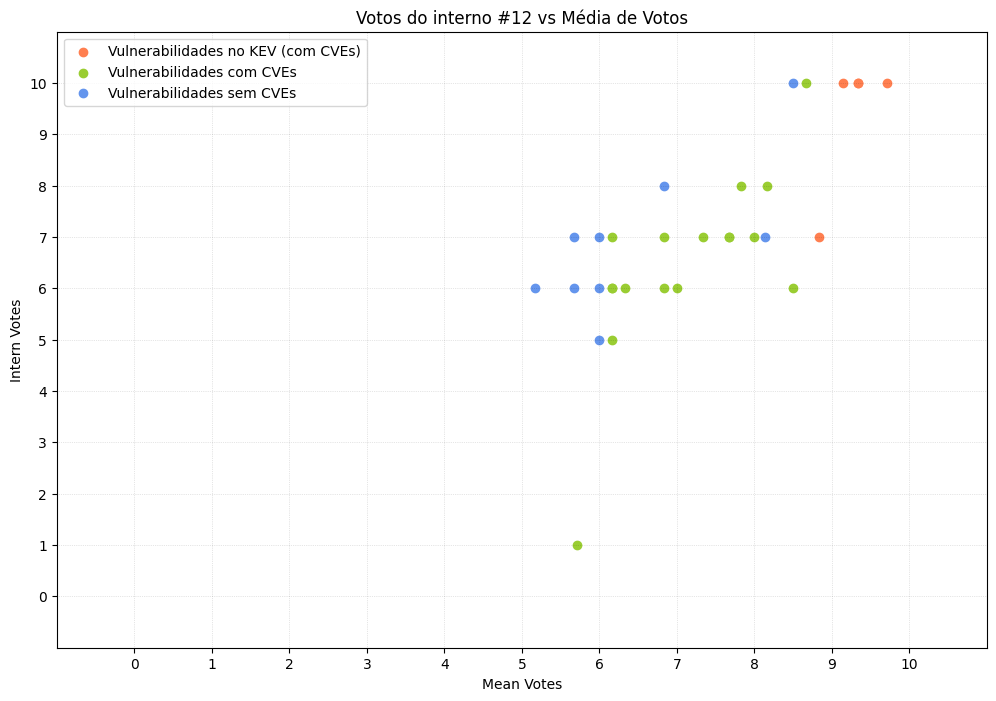

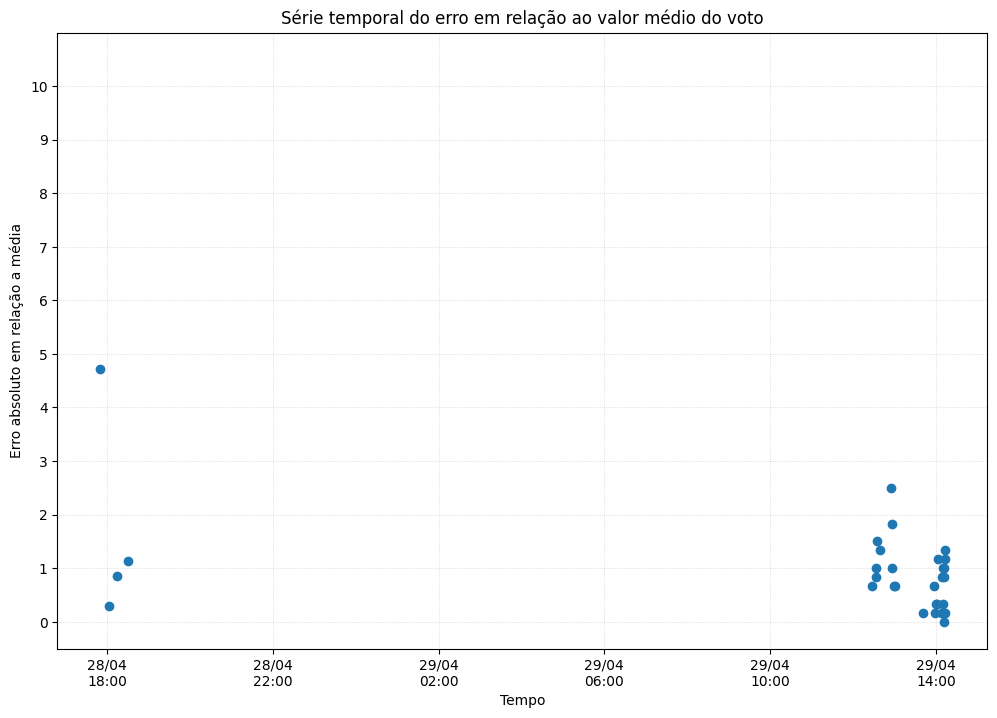

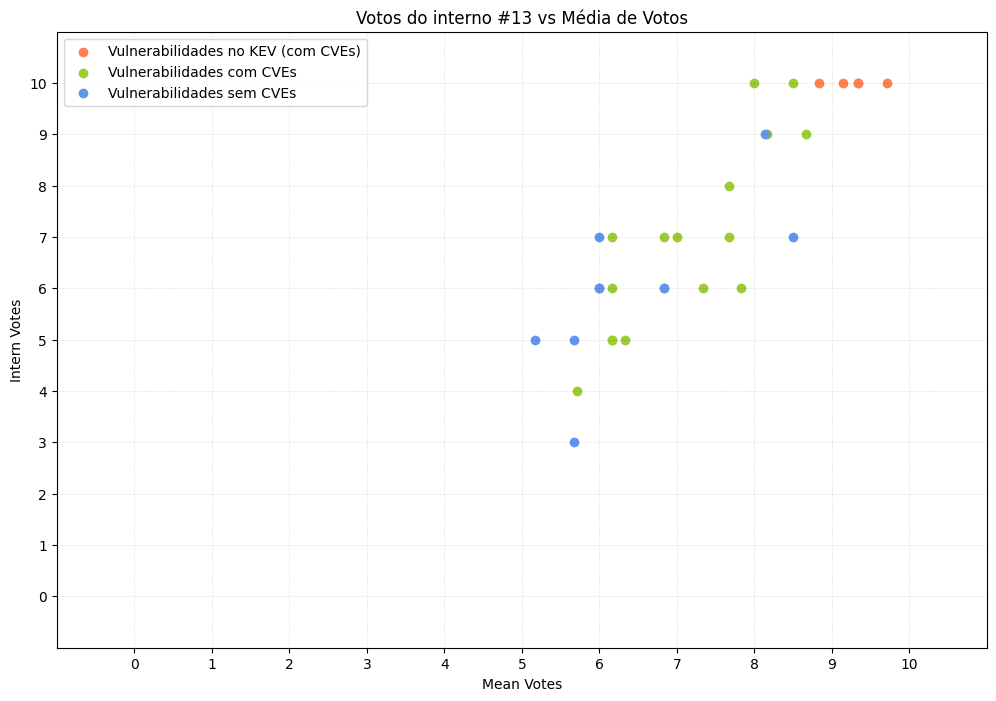

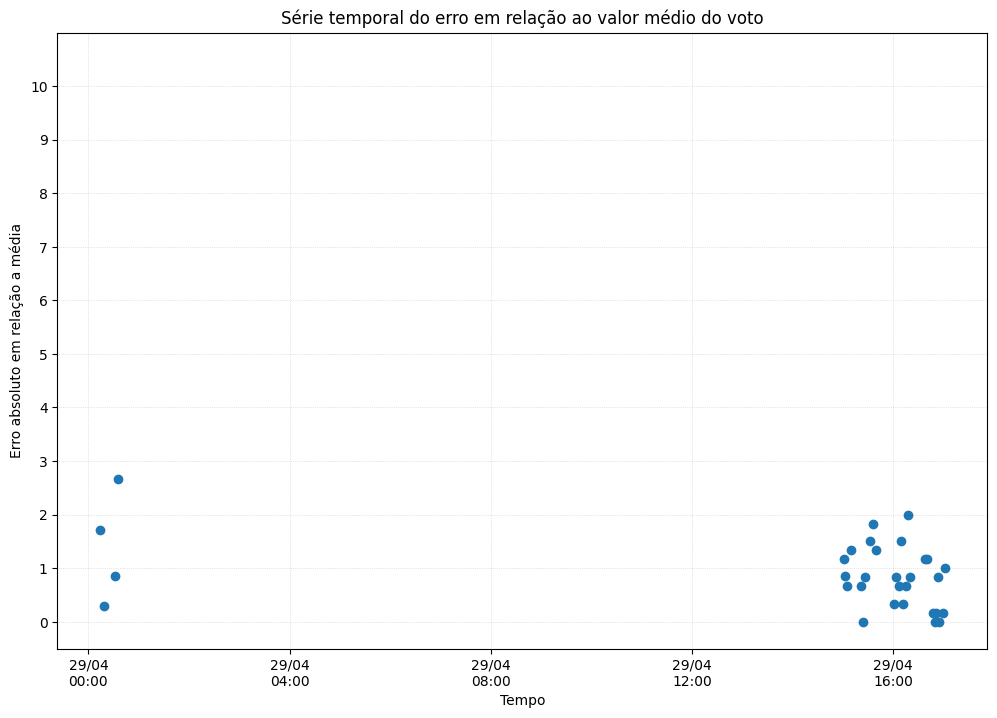

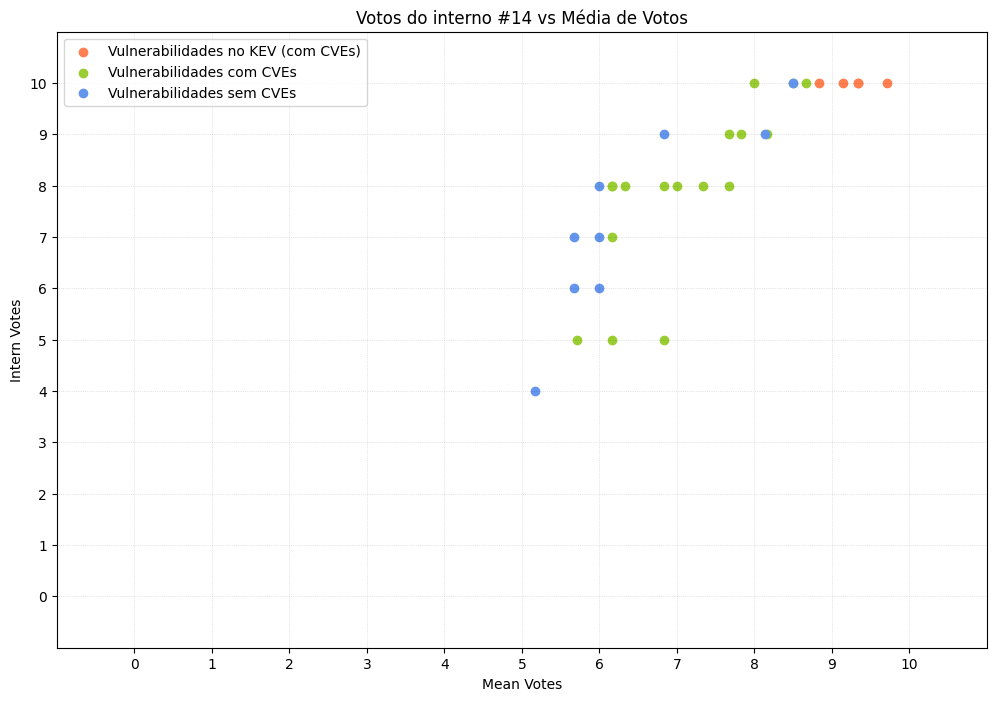

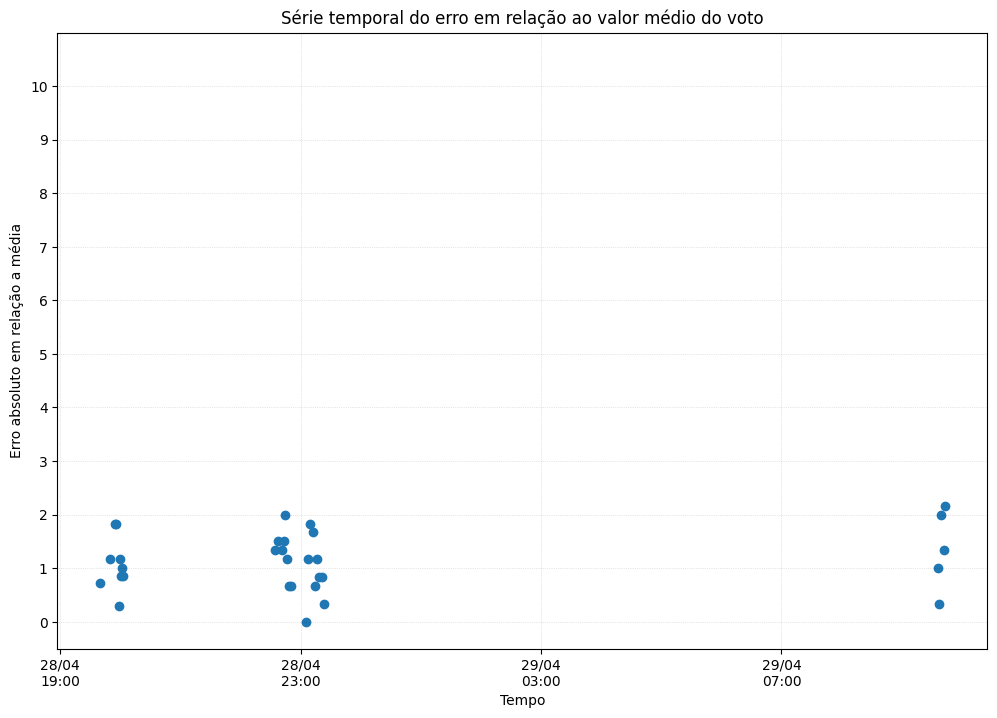

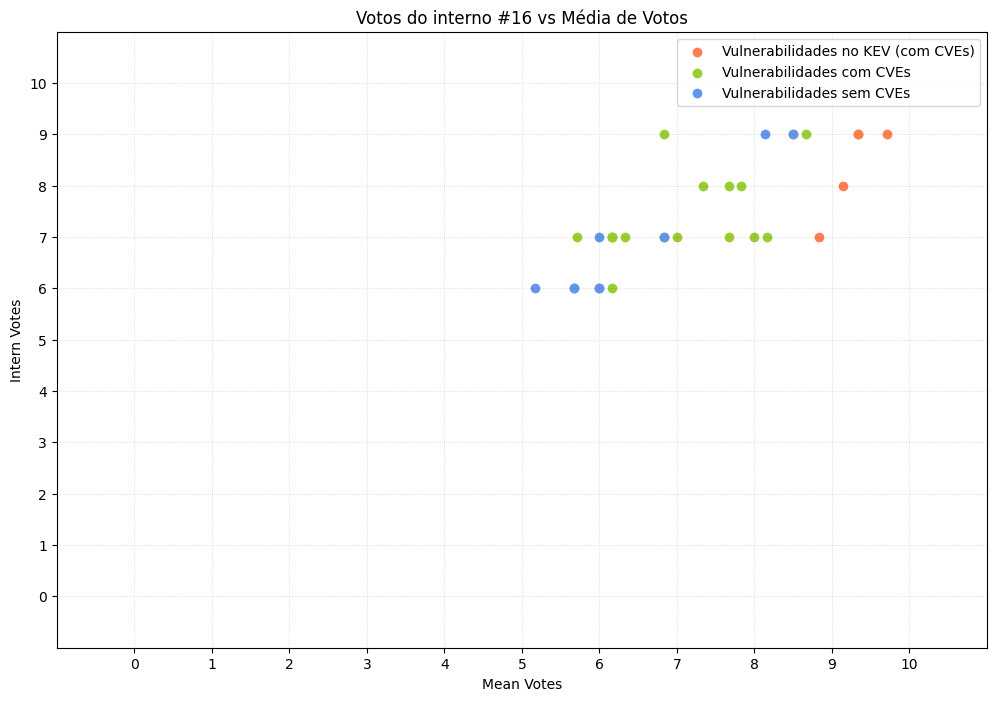

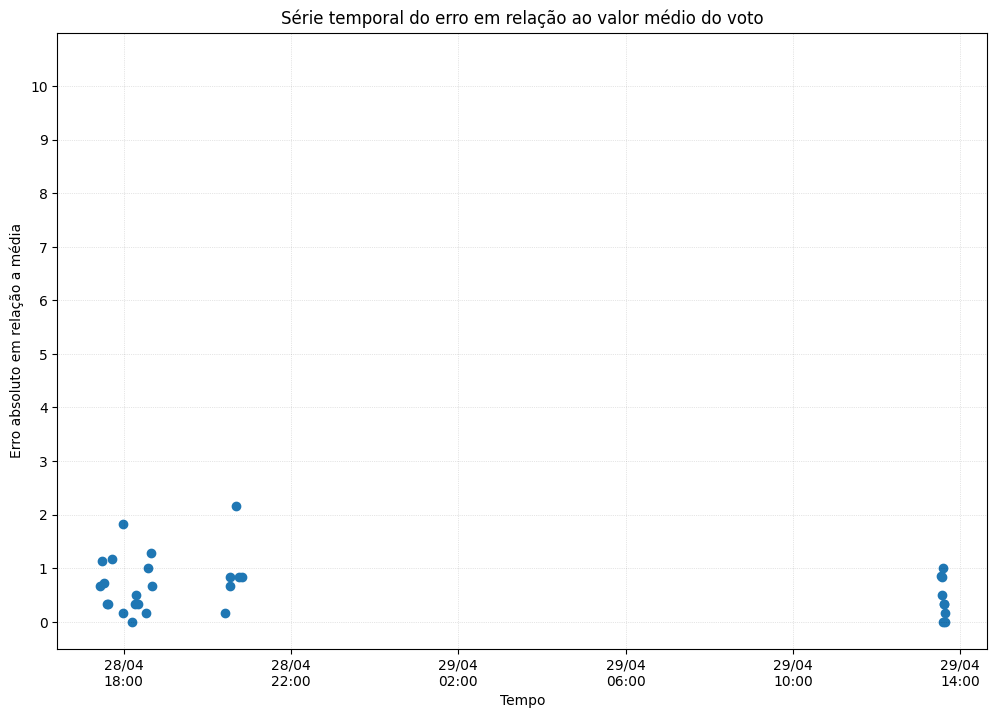

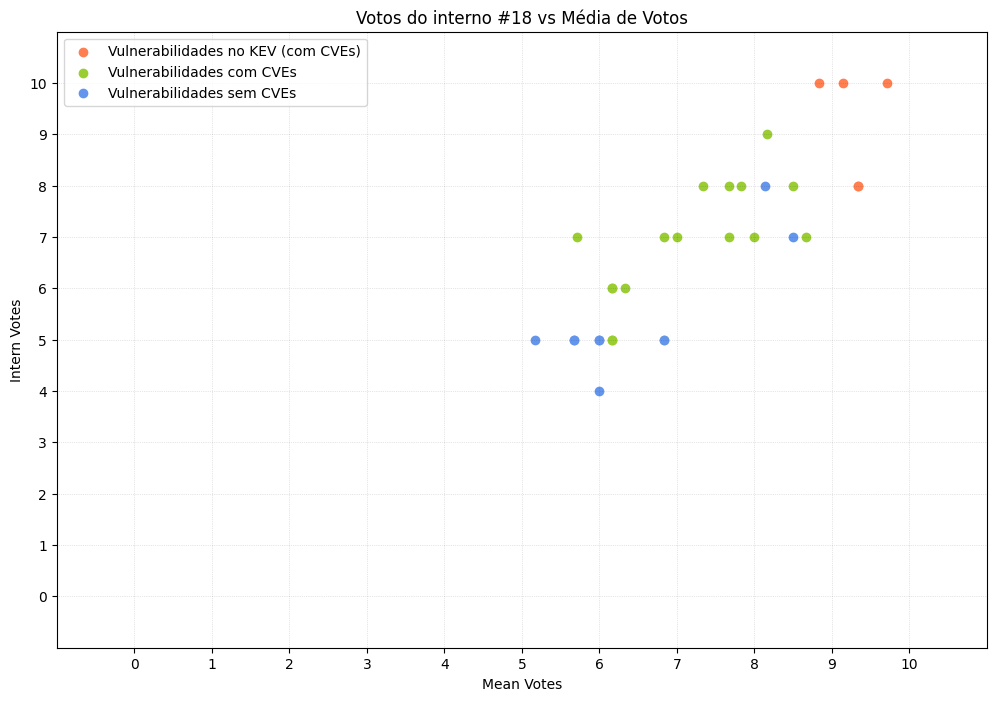

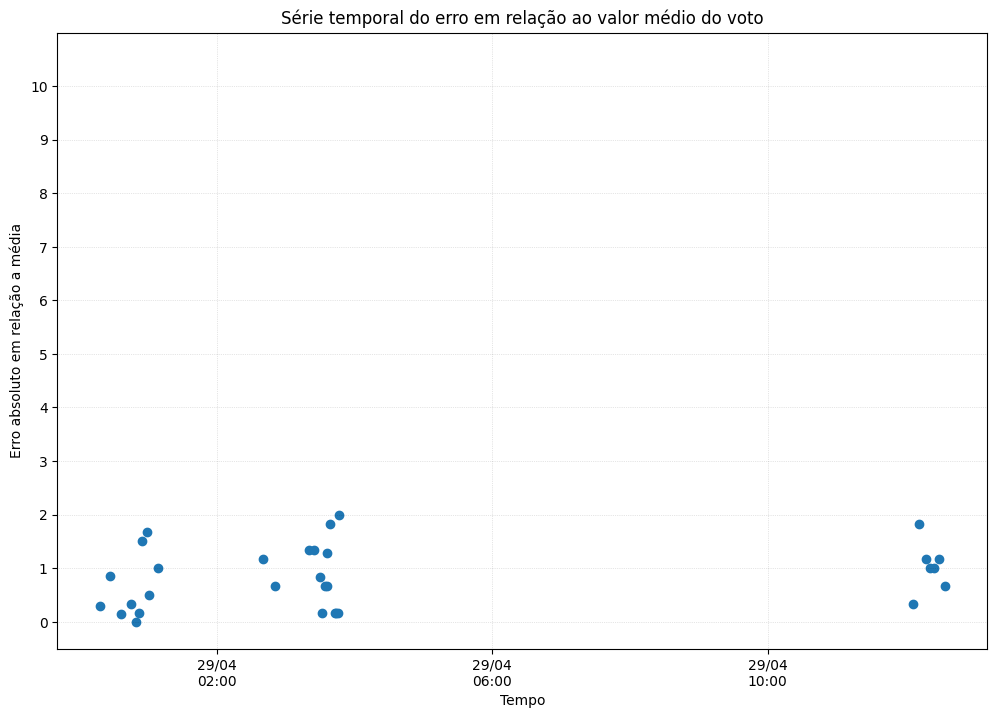

In [16]:
def plot_votes_vs_mean(intern, votes_intern, mean_votes):
    plt.figure(figsize=(12, 8))
    plt.scatter(mean_votes.loc[votes_intern[votes_intern["in_kev"]]["finding_id"].values], votes_intern[votes_intern["in_kev"]]["vote_num"], color="coral", label="Vulnerabilidades no KEV (com CVEs)")
    plt.scatter(mean_votes.loc[votes_intern[votes_intern["has_cve"]]["finding_id"].values], votes_intern[votes_intern["has_cve"]]["vote_num"], color="yellowgreen", label="Vulnerabilidades com CVEs")
    plt.scatter(mean_votes.loc[votes_intern[votes_intern["no_cve"]]["finding_id"].values], votes_intern[votes_intern["no_cve"]]["vote_num"], color="cornflowerblue", label="Vulnerabilidades sem CVEs")
  
    plt.legend()
    plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
    plt.title(f"Votos do interno #{intern} vs Média de Votos")
    plt.xlim(-1,11)
    plt.ylim(-1,11)
    plt.yticks(np.arange(0, 11, 1))
    plt.xticks(np.arange(0, 11, 1))
    plt.ylabel("Intern Votes")
    plt.xlabel("Mean Votes")
    plt.plot()

for intern in interns:
  # TODO investigate off by one errors
  # get the vulnerabilities that the intern voted on

  votes_intern = df_vn[df_vn["user_id"] == intern].copy()

  # Scatter of findings
  votes_intern["in_kev"] = votes_intern["finding_id"].apply(lambda x: x in in_kev)
  votes_intern["has_cve"] = votes_intern["finding_id"].apply(lambda x: x in has_cve)
  votes_intern["no_cve"] = votes_intern["finding_id"].apply(lambda x: x in no_cve)
  
  plot_votes_vs_mean(intern, votes_intern, mean_votes)# voted_ids = set(votes.keys())
  
  # 2 - Top 3 findings with the greatest difference between the intern and the mean votes
  votes_intern["avg_error"] = abs(votes_intern["vote_num"] - votes_intern["finding_id"].map(mean_votes["vote_num"]))
  votes_intern.sort_values(by="avg_error", ascending=False, inplace=True)
  # TODO: generate report to create email
  
  # 3 - Findings ordered by timestamp and ploted by error
  votes_intern.sort_values(by="timestamp", ascending=True, inplace=True)
  
  plt.figure(figsize=(12, 8))
  plt.scatter(votes_intern["timestamp"], votes_intern["avg_error"])
  
  plt.ylim(-0.5, 11)
  plt.yticks(np.arange(0, 11, 1))
  plt.ylabel("Erro absoluto em relação a média")
  plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
  plt.title("Série temporal do erro em relação ao valor médio do voto")
  
  delta_timestamp = votes_intern["timestamp"].max() - votes_intern["timestamp"].min()
  
  if delta_timestamp < datetime.timedelta(minutes=1):
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(bysecond=range(0, 60, 2)))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
  elif delta_timestamp < datetime.timedelta(hours=0.5):
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
  elif delta_timestamp < datetime.timedelta(hours=1):
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
  elif delta_timestamp < datetime.timedelta(hours=3):
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
  elif delta_timestamp < datetime.timedelta(hours=6):
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M:%S"))
  elif delta_timestamp < datetime.timedelta(days=1):
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m\n%H:%M"))
  elif delta_timestamp < datetime.timedelta(days=7):
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))

  plt.xlabel("Tempo")
  plt.plot()
  del votes_intern    
  

Top 3 findings with greatest difference for intern #5:
    finding_id  vote_num  avg_error
0            0        10   4.285714
14           2         8   1.142857
21           3         7   1.142857
Top 3 findings with greatest difference for intern #10:
     finding_id  vote_num  avg_error
70           11         7   1.666667
136          22         8   1.166667
52            8         5   1.166667
Top 3 findings with greatest difference for intern #12:
    finding_id  vote_num  avg_error
2            0         1   4.714286
77          12         6   2.500000
89          14         7   1.833333
Top 3 findings with greatest difference for intern #13:
     finding_id  vote_num  avg_error
168          27         3   2.666667
84           13        10   2.000000
120          19         6   1.833333
Top 3 findings with greatest difference for intern #14:
     finding_id  vote_num  avg_error
181          29         9   2.166667
187          30         8   2.000000
85           13        10 

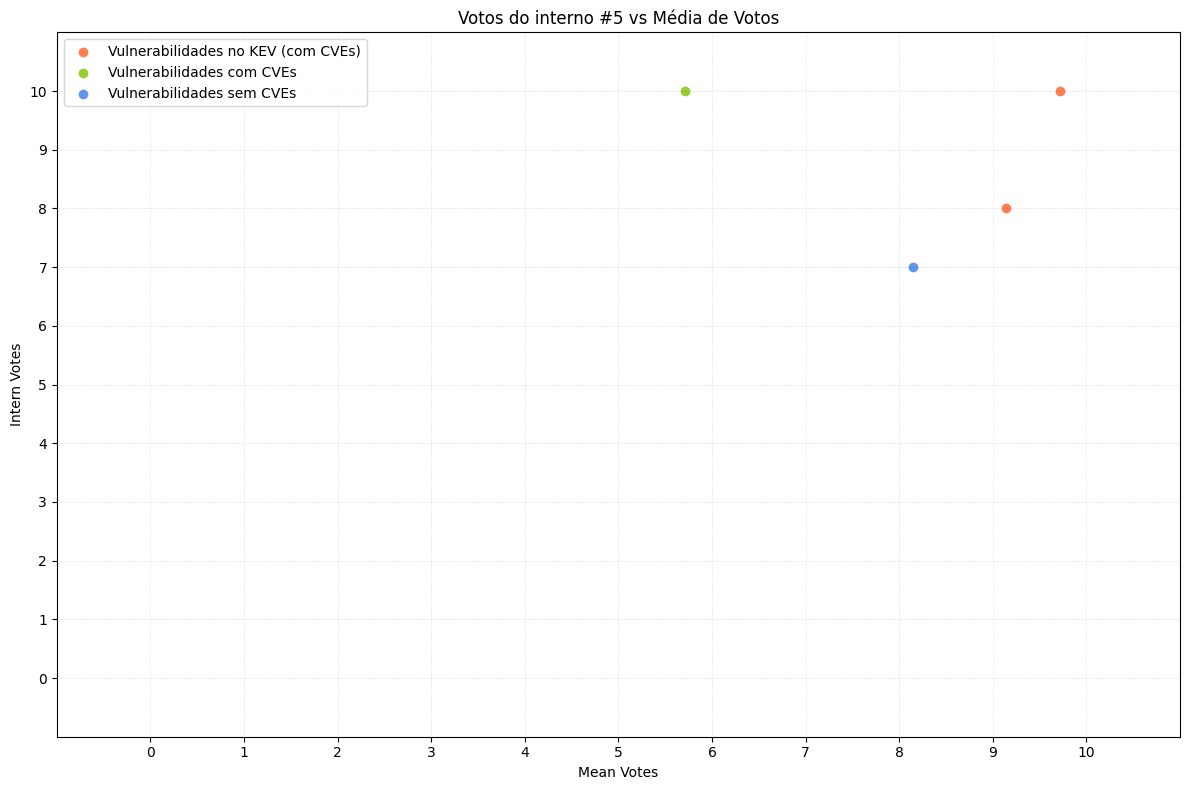

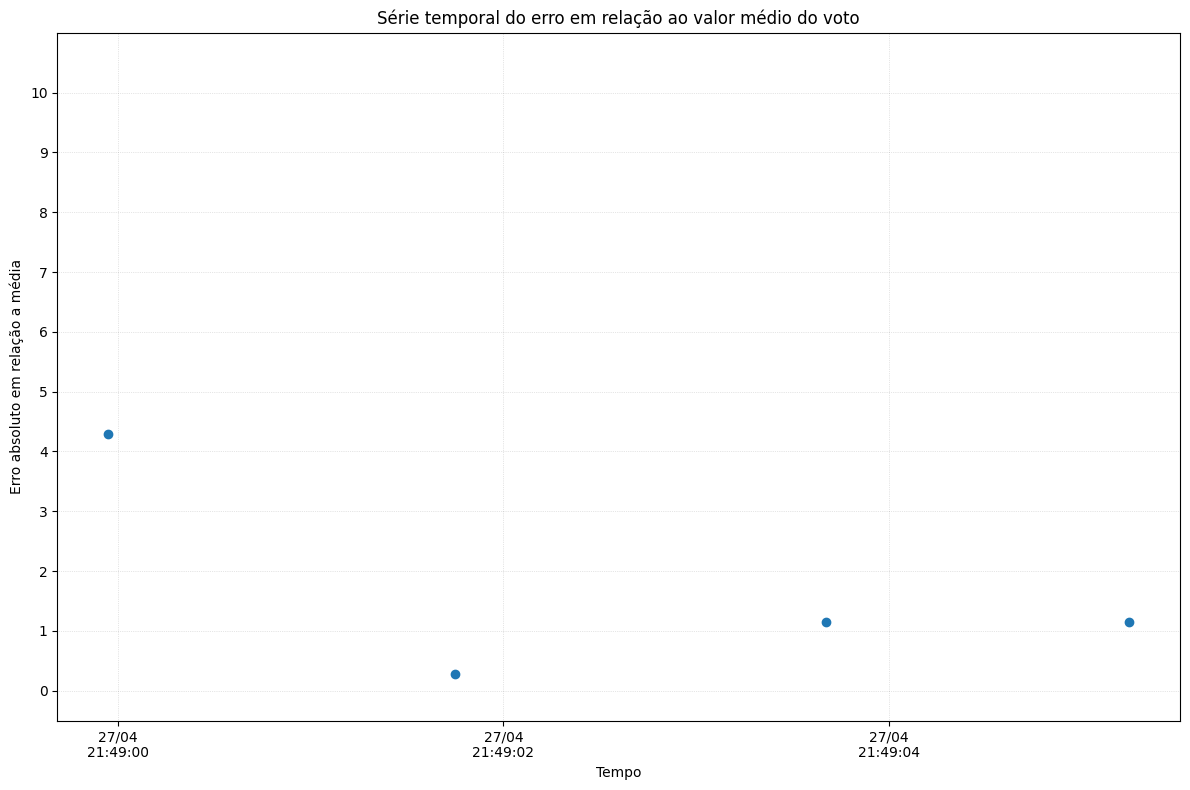

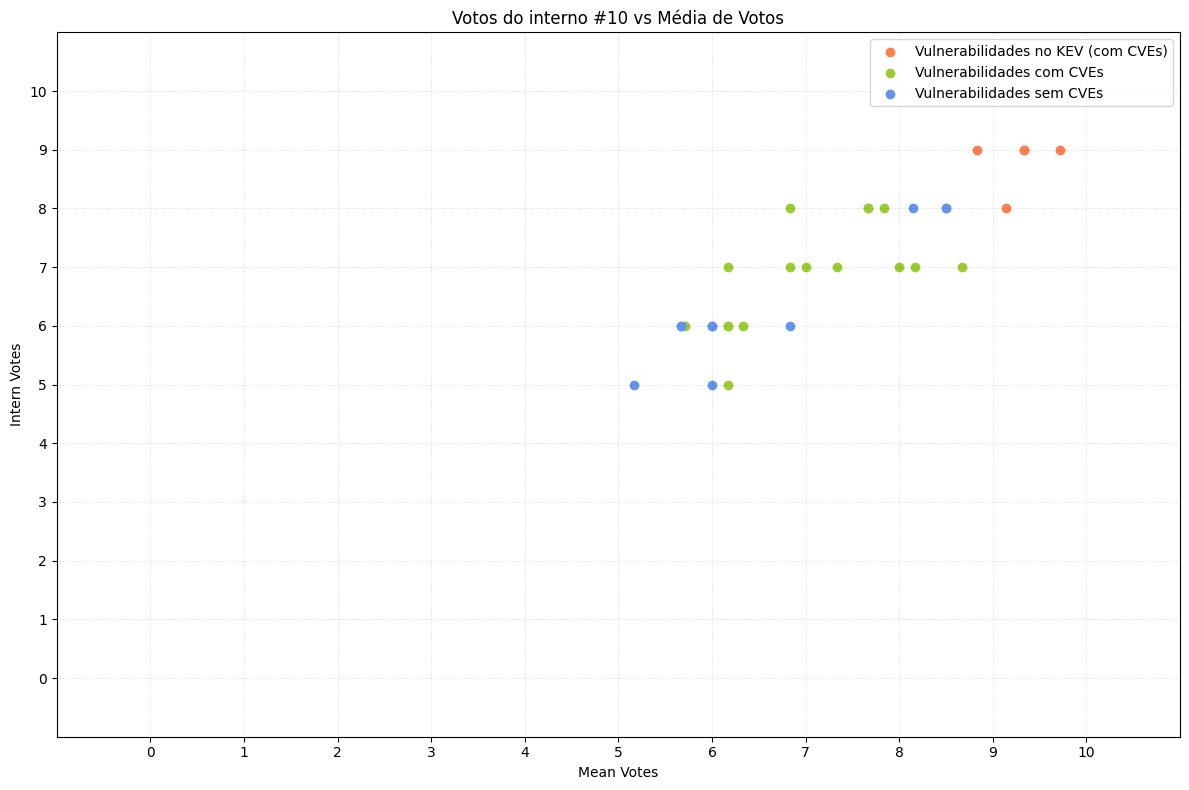

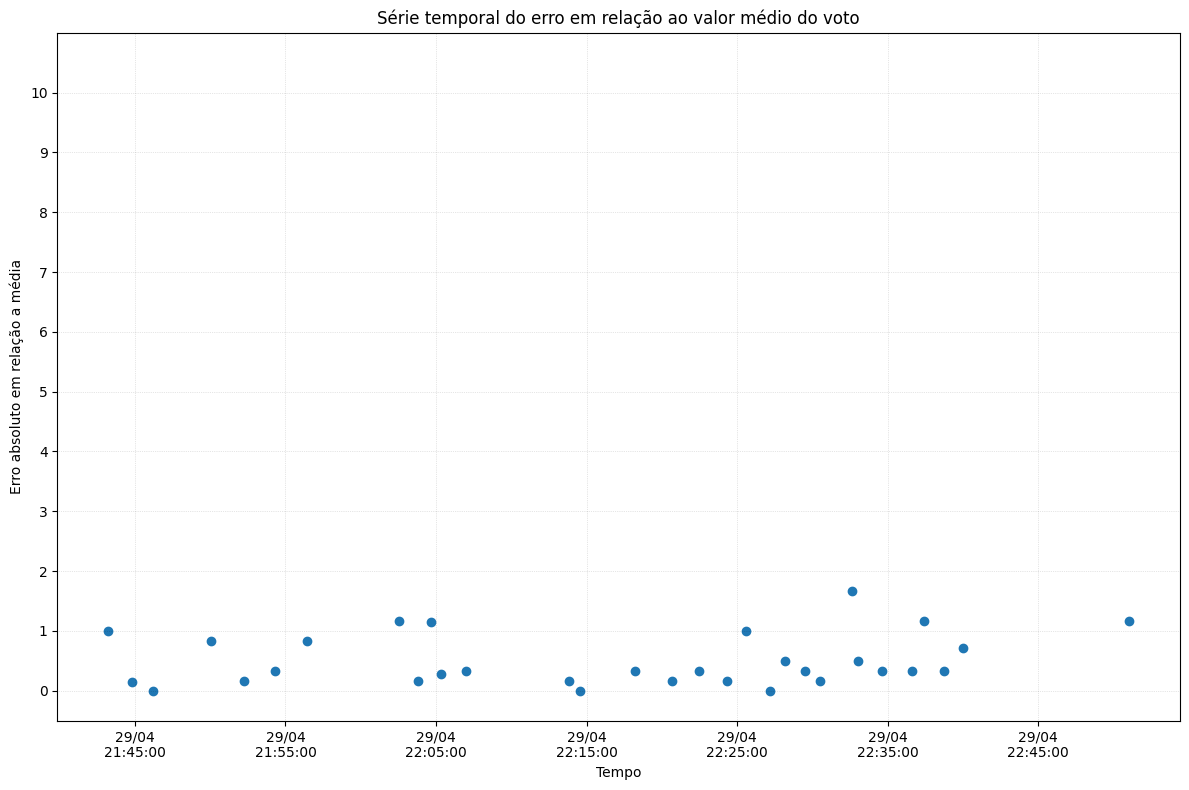

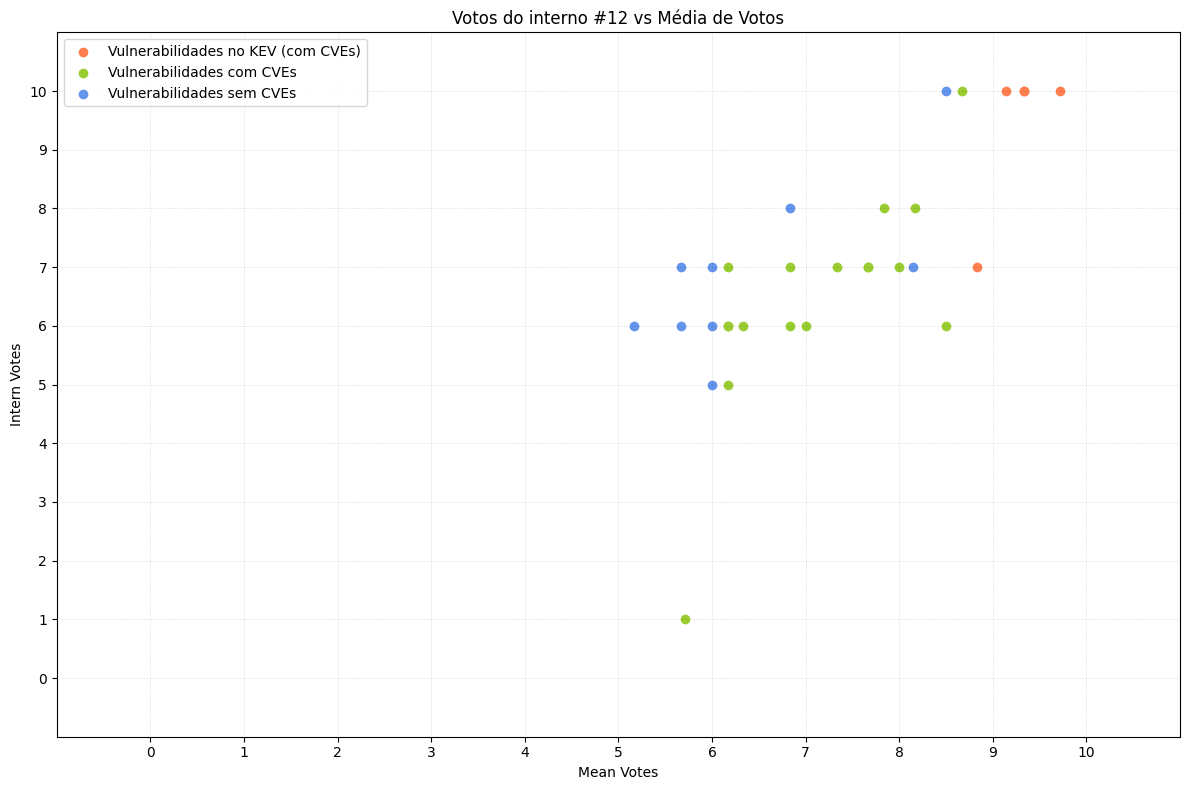

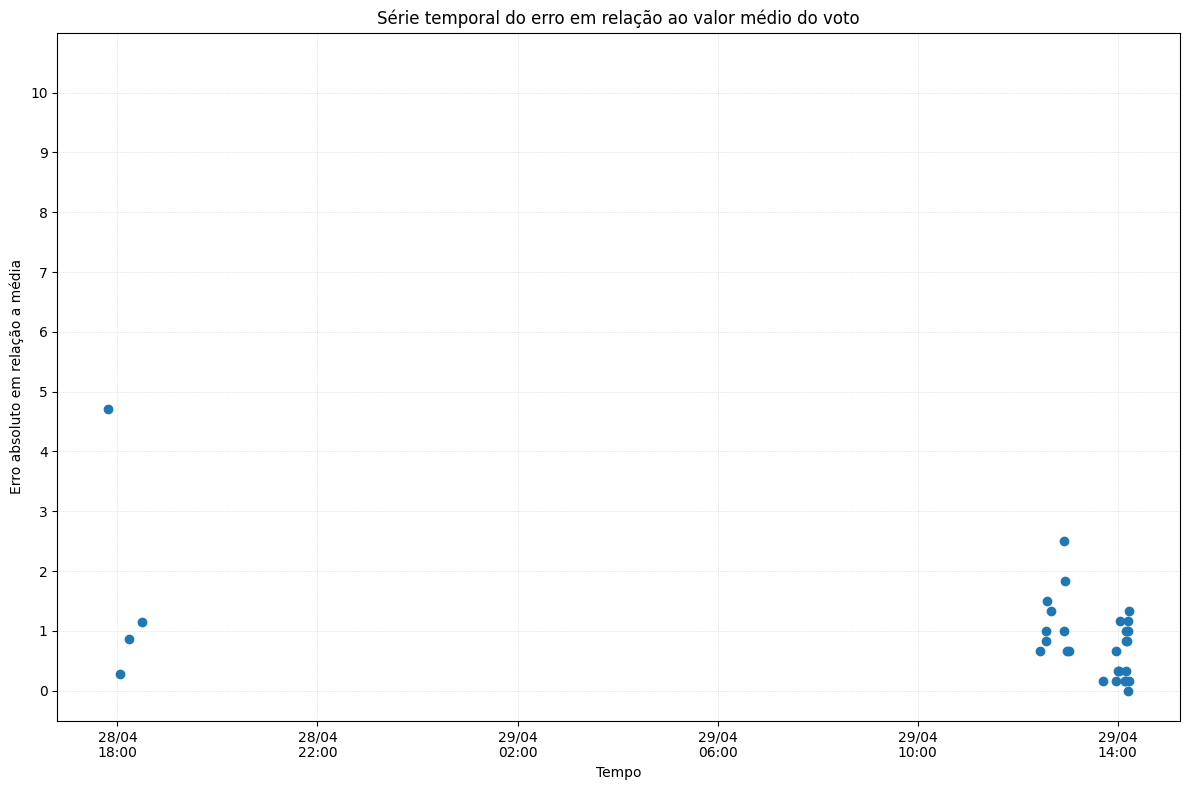

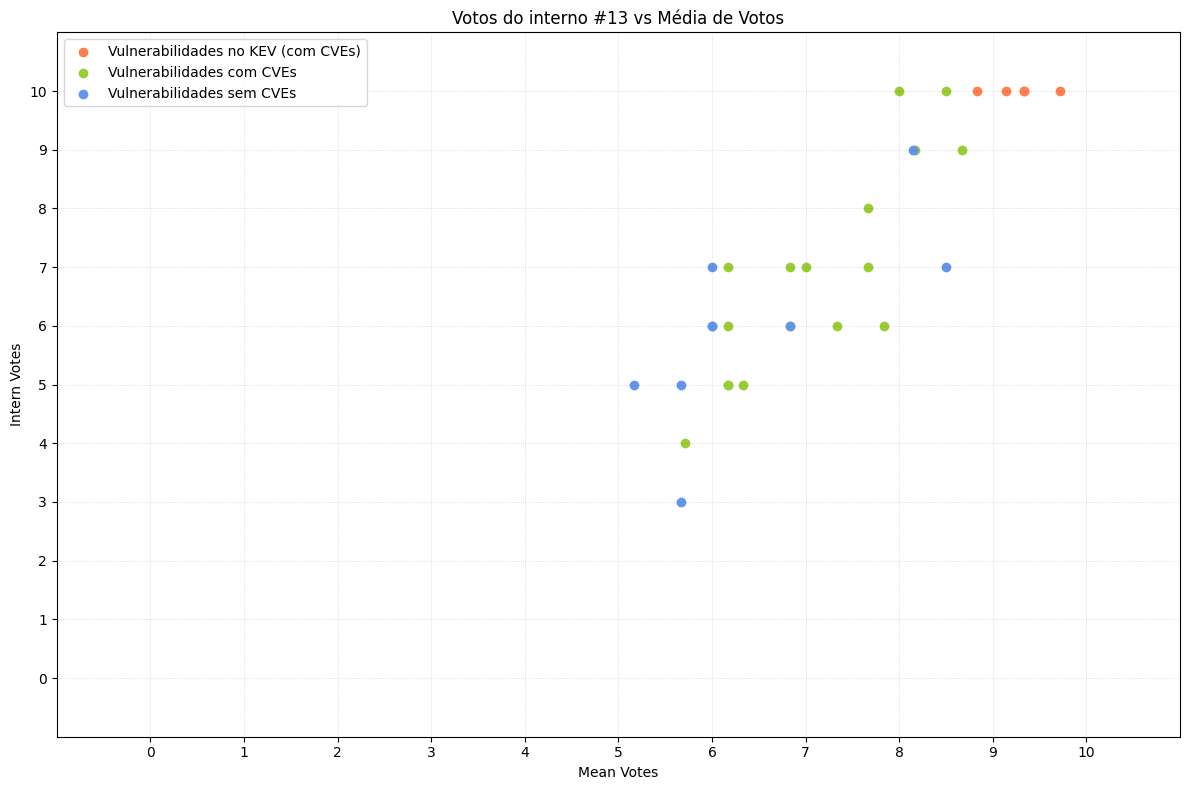

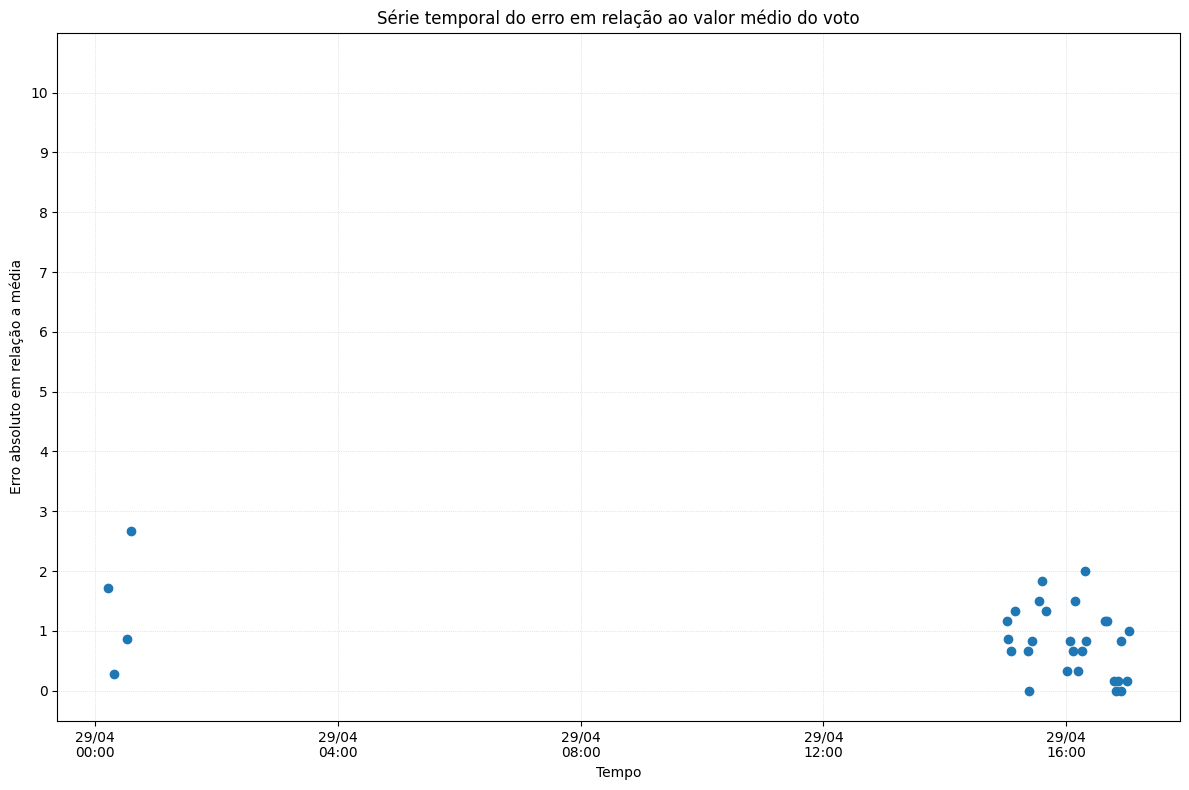

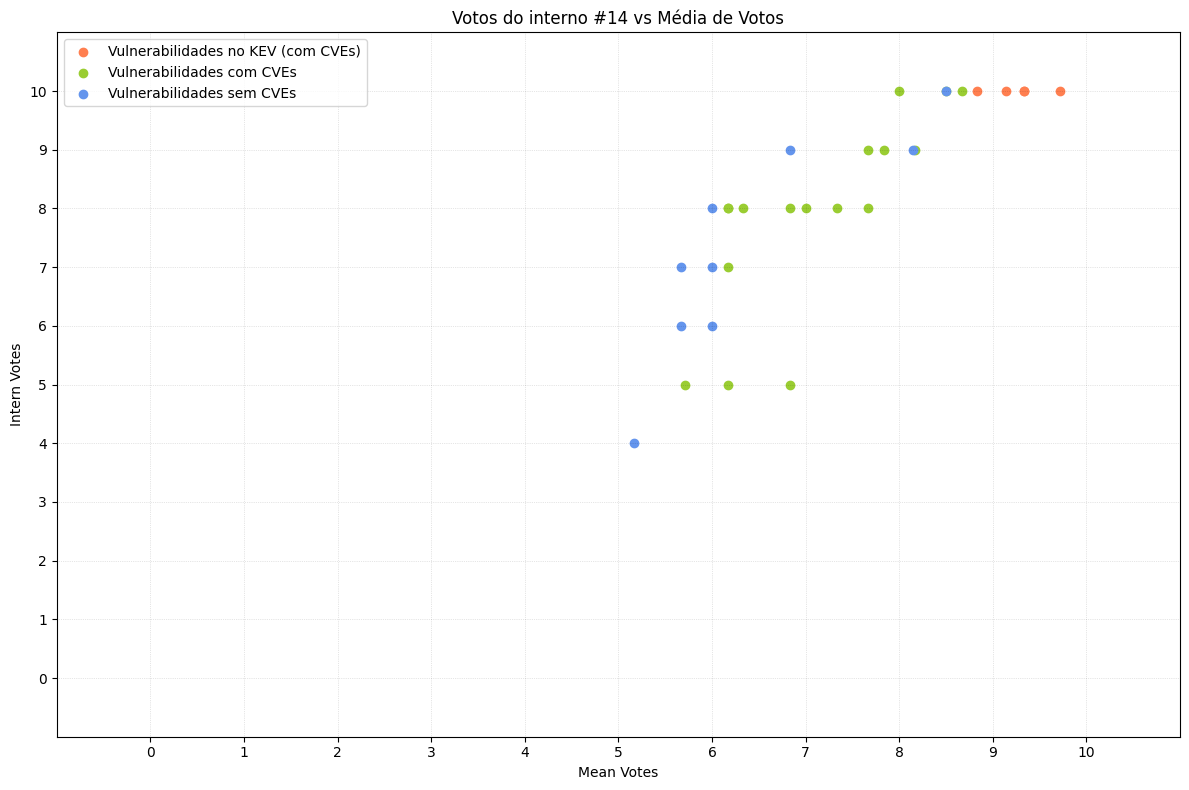

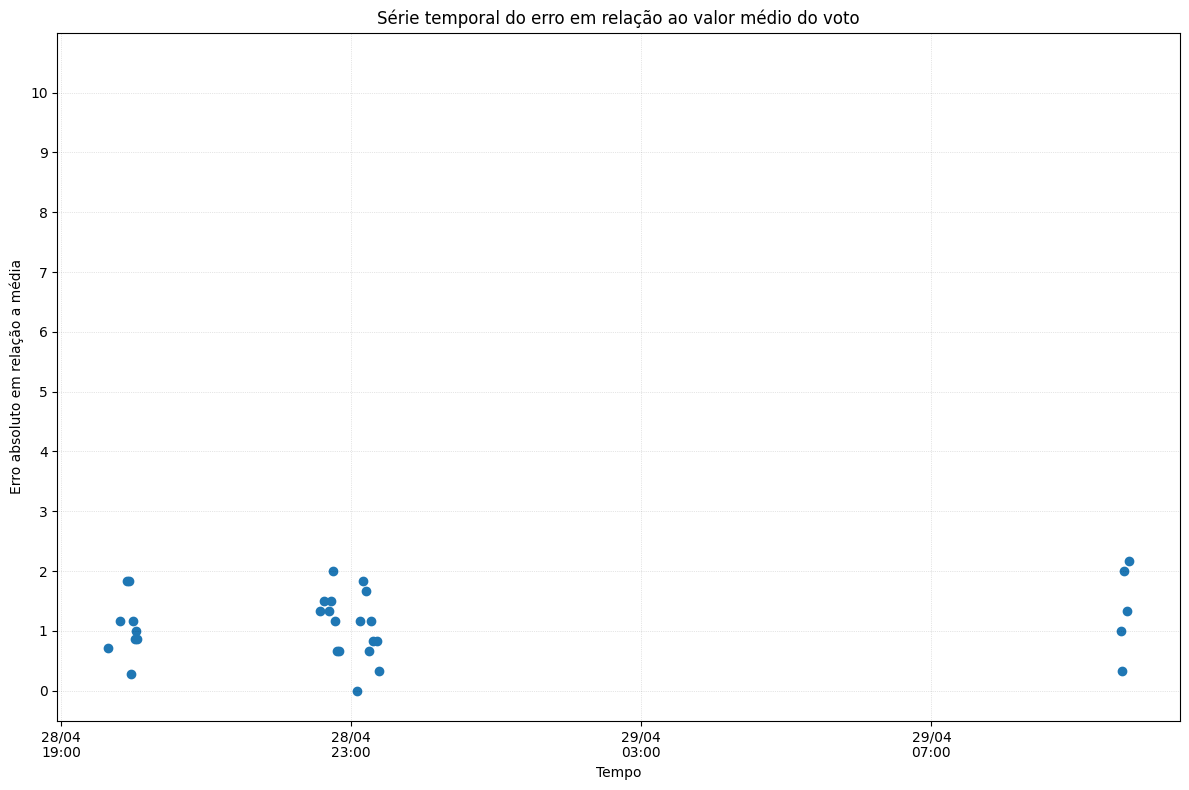

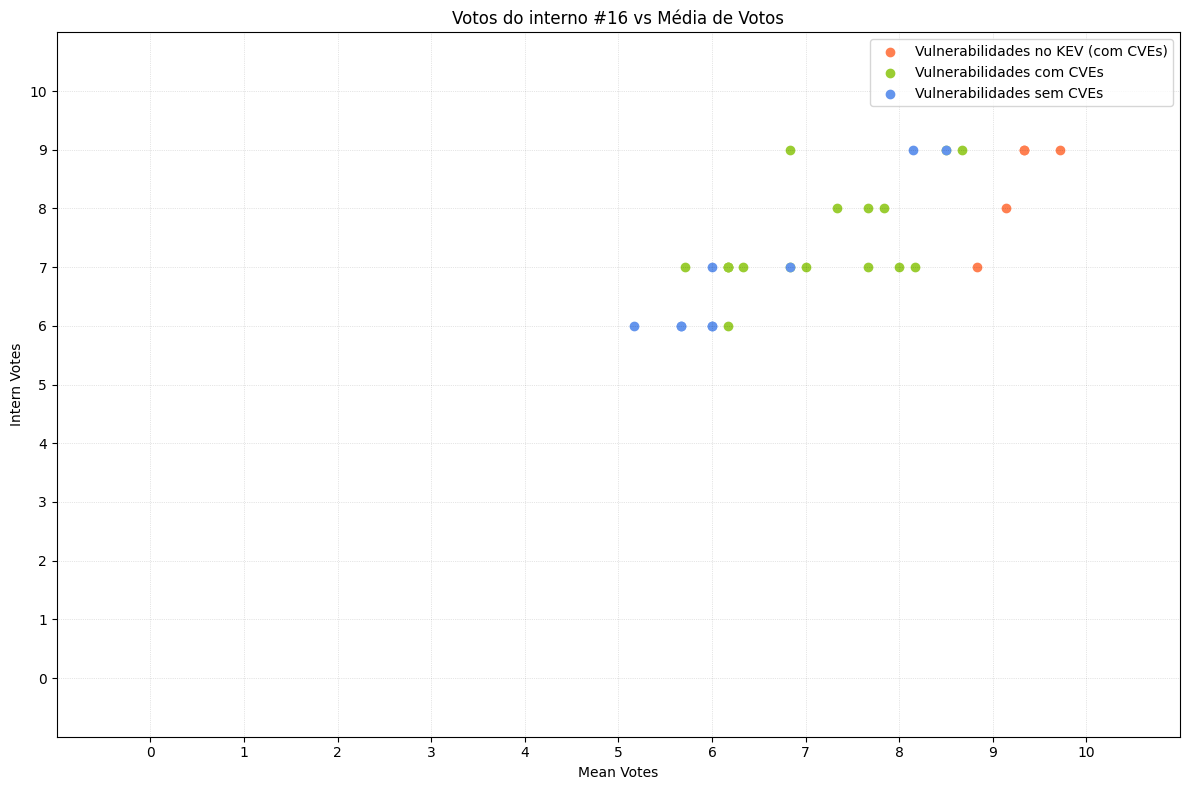

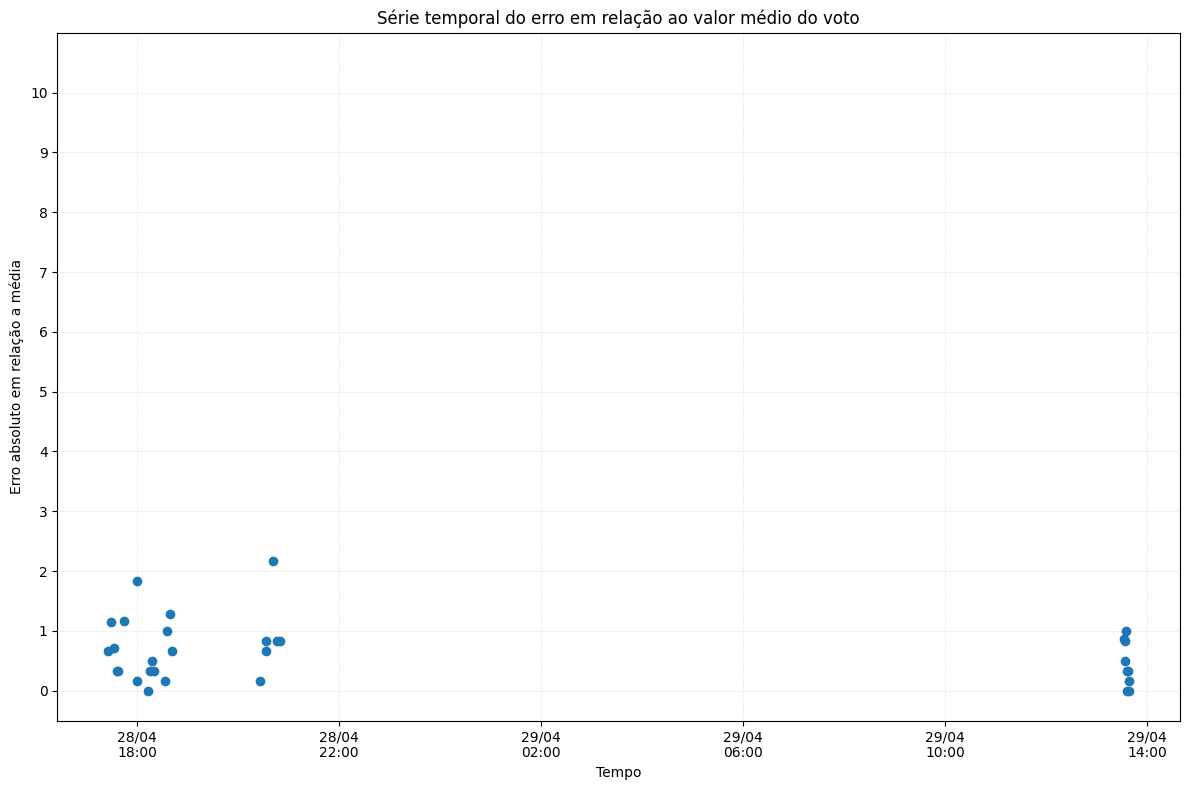

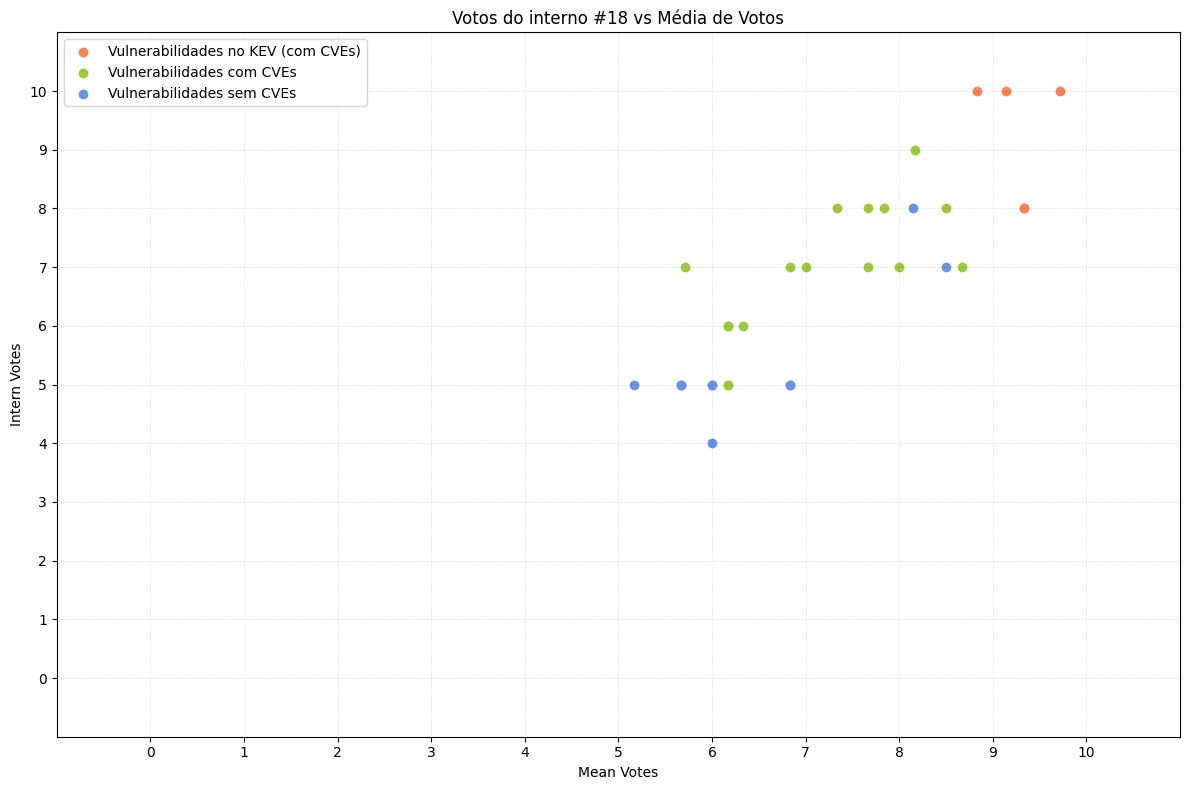

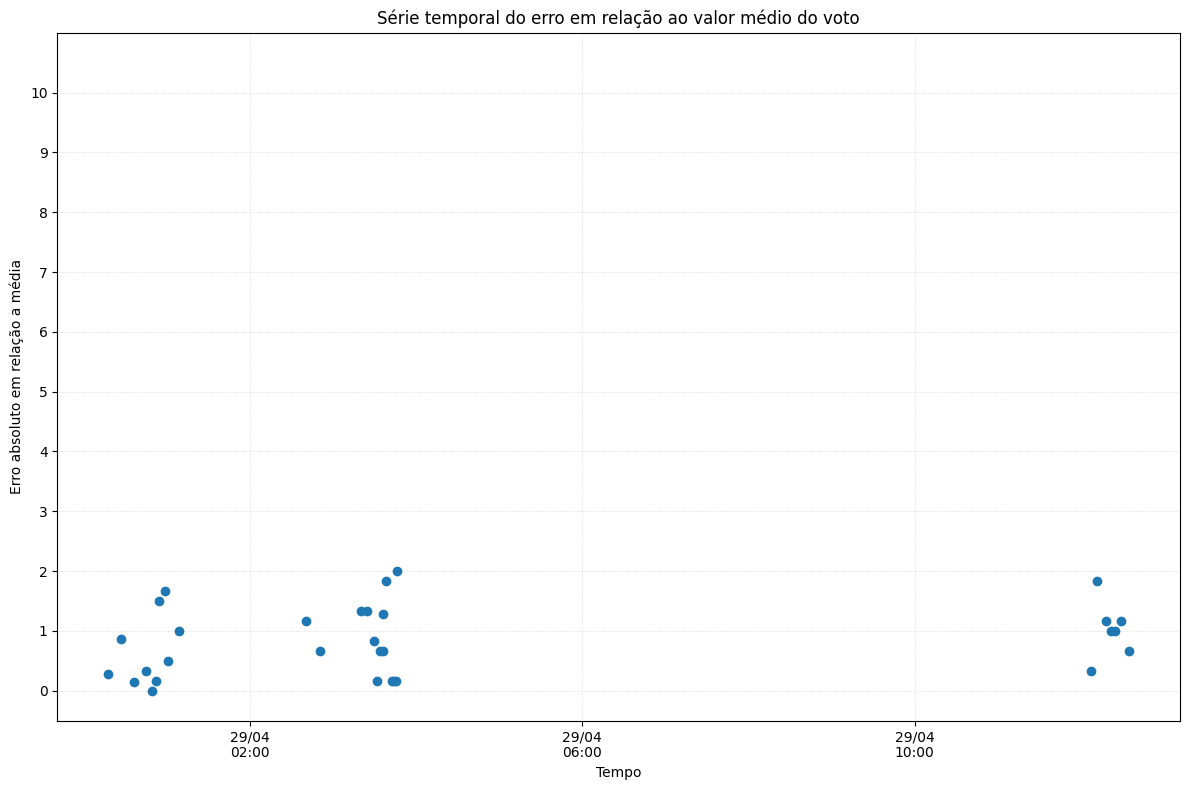

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
import pandas as pd


def plot_votes_vs_mean(intern_id, votes_df, mean_votes_df):
    """
    Plot the comparison between an intern's votes and mean votes with different colors
    based on vulnerability categories.
    
    Args:
        intern_id: ID of the intern being analyzed
        votes_df: DataFrame with the intern's votes
        mean_votes_df: DataFrame with mean votes for each finding
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each category with different colors
    categories = [
        ("in_kev", "coral", "Vulnerabilidades no KEV (com CVEs)"),
        ("has_cve", "yellowgreen", "Vulnerabilidades com CVEs"),
        ("no_cve", "cornflowerblue", "Vulnerabilidades sem CVEs")
    ]
    
    for category, color, label in categories:
        category_df = votes_df[votes_df[category]]
        finding_ids = category_df["finding_id"].values
        
        plt.scatter(
            mean_votes_df.loc[finding_ids]["vote_num"], 
            category_df["vote_num"], 
            color=color, 
            label=label
        )
  
    # Configure plot appearance
    plt.legend()
    plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
    plt.title(f"Votos do interno #{intern_id} vs Média de Votos")
    plt.xlim(-1, 11)
    plt.ylim(-1, 11)
    plt.yticks(np.arange(0, 11, 1))
    plt.xticks(np.arange(0, 11, 1))
    plt.ylabel("Intern Votes")
    plt.xlabel("Mean Votes")
    plt.tight_layout()


def plot_error_over_time(votes_df):
    """
    Plot the absolute error over time for an intern's votes.
    
    Args:
        votes_df: DataFrame with the intern's votes and error information
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(votes_df["timestamp"], votes_df["avg_error"])
    
    # Configure plot appearance
    plt.ylim(-0.5, 11)
    plt.yticks(np.arange(0, 11, 1))
    plt.ylabel("Erro absoluto em relação a média")
    plt.grid(True, linestyle=":", linewidth=0.5, color='black', alpha=0.2)
    plt.title("Série temporal do erro em relação ao valor médio do voto")
    
    # Set x-axis formatting based on time range
    configure_time_axis(votes_df["timestamp"])
    
    plt.xlabel("Tempo")
    plt.tight_layout()


def configure_time_axis(timestamp_series):
    """
    Configure the time axis formatting based on the time range.
    
    Args:
        timestamp_series: Series of timestamps to be displayed
    """
    delta_timestamp = timestamp_series.max() - timestamp_series.min()
    
    # Define formatting based on the time range
    time_formats = [
        (datetime.timedelta(minutes=1), mdates.SecondLocator(bysecond=range(0, 60, 2)), "%d/%m\n%H:%M:%S"),
        (datetime.timedelta(hours=0.5), mdates.MinuteLocator(interval=1), "%d/%m\n%H:%M:%S"),
        (datetime.timedelta(hours=1), mdates.MinuteLocator(interval=5), "%d/%m\n%H:%M:%S"),
        (datetime.timedelta(hours=3), mdates.MinuteLocator(interval=10), "%d/%m\n%H:%M:%S"),
        (datetime.timedelta(hours=6), mdates.HourLocator(interval=1), "%d/%m\n%H:%M:%S"),
        (datetime.timedelta(days=1), mdates.HourLocator(interval=4), "%d/%m\n%H:%M"),
        (datetime.timedelta(days=7), mdates.DayLocator(interval=1), "%d/%m")
    ]
    
    # Apply the appropriate formatting
    for threshold, locator, format_str in time_formats:
        if delta_timestamp < threshold:
            plt.gca().xaxis.set_major_locator(locator)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(format_str))
            break


def analyze_intern_votes(intern_id, df_vn, mean_votes, category_sets):
    """
    Analyze votes from a specific intern and generate visualizations.
    
    Args:
        intern_id: ID of the intern to analyze
        df_vn: DataFrame with all votes
        mean_votes: DataFrame with mean votes for each finding
        category_sets: Dictionary of sets containing finding IDs for each category
    """
    # Get the vulnerabilities that the intern voted on
    votes_intern = df_vn[df_vn["user_id"] == intern_id].copy()
    
    if votes_intern.empty:
        print(f"No votes found for intern #{intern_id}")
        return
    
    # Categorize findings
    for category, id_set in category_sets.items():
        votes_intern[category] = votes_intern["finding_id"].apply(lambda x: x in id_set)
    
    # 1. Plot votes comparison
    plot_votes_vs_mean(intern_id, votes_intern, mean_votes)
    
    # 2. Calculate and sort by error for reporting
    votes_intern["avg_error"] = abs(votes_intern["vote_num"] - votes_intern["finding_id"].map(mean_votes["vote_num"]))
    
    # Get top 3 findings with greatest difference for reporting
    top_errors = votes_intern.sort_values(by="avg_error", ascending=False).head(3)
    print(f"Top 3 findings with greatest difference for intern #{intern_id}:")
    print(top_errors[["finding_id", "vote_num", "avg_error"]])
    # save data for template

    # 3. Plot error over time
    votes_intern.sort_values(by="timestamp", ascending=True, inplace=True)
    plot_error_over_time(votes_intern)

def main(df_vn, interns, mean_votes):
    """
    Main function to analyze all interns' votes.
    
    Args:
        df_vn: DataFrame with all votes
        interns: List of intern IDs to analyze
        mean_votes: DataFrame with mean votes for each finding
    """
    # Define category sets
    category_sets = {
        "in_kev": in_kev,
        "has_cve": has_cve,
        "no_cve": no_cve
    }
    
    # Analyze each intern's votes
    for intern_id in interns:
        analyze_intern_votes(intern_id, df_vn, mean_votes, category_sets)


# Example usage:
main(df_vn, interns, mean_votes)